# Implementing "Dynamic Routing between Capsules"
by Sara Sabour Nicholas Frosst and Geoffrey E. Hinton 1)
# Motivation
I decided to do this topic when I saw the pictures of the Multi-MNIST dataset (Figure 5). They reminded me of bin picking, a prominent problem in computer vision, where the recognition of objects is hard because they are partially covered by one another.
# The problem:
Convolutional Neural Networks (CNNs) do such a good job in image recognition that they have become the standard approach for such tasks. A basic idea about multilayered CNNs is that lower levels recognize primitive features, f.e. lines, while higher levels recognize more complicated features, f.e. edges, triangles, circles, faces or cats.
The usual way to propagate information from one level to another is by a single number for an image area and the usual way to sort out what is relevant within it is through maximum pooling, meaning that within a pooling area, only the mostly exited feature detector delivers information to the next level. The number conveys only the information that a lower level feature is present to some degree, but where it is located within the the pooling group gets lost.
There is a nice examples of how the mouth and one eye can change places and the result is still recognized as a face. 2)
Further, features in an image are not only present or not present or present to some degree, but they have instantiation parameters, like size, orientation, position and so on.
# The proposed solution:
According to the authors, a better way to pass information from the feature detectors to the next level is to use a vector instead of a single number. The vector is produced by a group of neurons called a capsule. They further propose to let the length of the vector represent the probability that the feature is present at all. As a probability, possible values for the vector length are between 0 and 1. This is achieved by a so called squashing funtion (Eq.1).
Capsule networks try to propagate the information from lower layers to the most apt receiver in the next layer. The most apt receiver is the one that produces the highest output from this information. This method called "routing by agreement". It is peformed by an iterative process: 
- Initiate coupling coefficients
- Feed input to all possible receivers
- Compute scalar product of receivers output times prediction
- Add scalar product to coupling coefficients, thus increasing coupling for good matches
- Repeat secong an following steps several (here 3) times

# Technical issues:
In file digitCaps, I have implemented a special Layer for the secondary capsules and the routing mechanism.
myModel implements the whole model of capsule net and the decoder for reconstruction. It also calculates losses and accuracy. Hence, it has a lot more output variables. For loss calculation, it needs the original labels as an additional input. Then, I needed a way to "inject" vaalues into the decoder part in order to try out, what effect the values in the capsule 2 output vector have. This is accomplished by 2 additional inputs: A bypass flag, which prevents the capsule layers from being executed and instead copies the v input values to the decoder input.
Problems:
I could not use the model.compile(),predict(),fit(), save() and load() methods. If I understood it right, this is because these methods belong to the functional model which can only be used if the data processing flow is unidirectional and without branches, loops or conditions. Here, the routing is done in a loop and repeated for 3 steps. Maybe the nonstandard inputs and outputs would also hinder the use of these methods.
As I learned from TensorFlow docs, a user defined model cannot be saved. The code that defines it is also necessary. Hence I choose to save only the weights. Storing the weights produces an index and 2 data files. The bigger one has 32Mb size and github limits file sizes to 25Mb. My kludgy workaround is to zip these files into a split archive, which has to be reassembled and unzipped after cloning the repository. I suppose there must be better solutions.

# Findings:
The trained model achieves an accuracy of 0.9914 on the test data, which is lower than in the paper.

The size of the parameters 8.2million parameters * 4 byte for float32 fits well the size of the weight files.

The decoder reconstructs the digits nicely.

Manipulation of the output vector components does not show clear results in most cases. I would assume that either there is some error in my code or the images in figure 4 are carefully selected lucky examples.
I tried to use a greater perturbation, which generates more visually intersting results.

1) Dynamic Routing between Capsules (https://arxiv.org/abs/1710.09829)

2) https://hackernoon.com/capsule-networks-are-shaking-up-ai-heres-how-to-use-them-c233a0971952



# Preparations

In [1]:
!git clone https://github.com/hergenhahn/caps.git
#!ls -l caps
!mv caps capsules
#assemble split archive
!cat capsules/weights.zip.001>/tmp/weights.zip
!cat capsules/weights.zip.002>>/tmp/weights.zip
!cat capsules/weights.zip.003>>/tmp/weights.zip
!unzip -o /tmp/weights.zip
#!ls -l capsules/
#!ls -l

%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from capsules.digitCaps import DigitCaps
from capsules.auxfunc import *
from capsules.myModel import MyModel


Cloning into 'caps'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
Archive:  /tmp/weights.zip
  inflating: capsules_weights-16-04-2020-15_41_36.data-00000-of-00002  
  inflating: capsules_weights-16-04-2020-15_41_36.data-00001-of-00002  
  inflating: capsules_weights-16-04-2020-15_41_36.index  


# New Section

# Train on MNIST

In [0]:
# Make moodel and train it for 10 epochs
#
# Check if the training ataset exists. If not load it.
#
batch_size = 50
try:
   train_dataset
except NameError:
   train_dataset, test_dataset, ntrain, ntest = loadMNIST(batch_size)
tf.keras.backend.clear_session()

epochs = 10
# Initialize the model.
mlp = MyModel()
set_verbosity(0)
#set_verbosity(1) # use to print shapes

optimizer = tf.keras.optimizers.Adam()
# Training
n_epoch = 10
nEpoch = ntrain // batch_size

for epoch in range(n_epoch):
  i=0
  for (x,t) in train_dataset:
    bs=x.shape[0]
    if bs==batch_size:                      # process only full batches
        i+=1   
        # Compute the output, loss and the gradients.
        with tf.GradientTape() as tape:
            loss, accuracy, rec_loss, reconstructed_image, y_test,y_pred,original_image=mlp({'x':x,'y':t,'bypass':False})
            gradients = tape.gradient(loss, mlp.trainable_variables)
            if i % 10 == 0:
              print("Ep.: {} Batch: {}/{} ({:.1f}%) Loss: {:.3f} RecLoss: {:.3f} Accuracy: {:.3f}".format(epoch,i, nEpoch, i * 100 / nEpoch ,loss.numpy(),rec_loss.numpy(),accuracy.numpy()))
        # Apply gradients.
            optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))

  print('evaluating...')
  sloss = 0
  srec_loss = 0
  saccuracy = 0

  n = 0 
  for (x,t) in test_dataset:
    act_batch_size=x.shape[0]
    if act_batch_size==batch_size:
      loss, accuracy, rec_loss, reconstructed_image, y_test,y_pred,original_image=mlp({'x':x,'y':t,'bypass':False})
      sloss += loss.numpy()
      srec_loss += rec_loss.numpy()
      saccuracy += accuracy.numpy()
      n+=1
      if n % 25 < 24:
        print(n,end=',')
      else:
        print(n)
  saccuracy /= n
  sloss /= n
  srec_loss /= n
  print("\nvloss:",sloss,"vrec_loss:",srec_loss, 'vaccuracy:', saccuracy)
  

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28) 0 .. 255 (60000,) (10000,)


KeyboardInterrupt: ignored

# Evaluate on MNIST test data

In [2]:
# Make Model, load pretraind weights and evaluate on test data:
#
set_verbosity(0)
batch_size = 50
try:
   train_dataset
except NameError:
   train_dataset, test_dataset, ntrain, ntest=loadMNIST(batch_size)

model = MyModel()
model.__init__()

#model.load_weights('/content/drive/My Drive/Colab Notebooks/capsules_weights-16-04-2020-15_41_36')
#model.load_weights('capsules/capsules_weights-16-04-2020-15_41_36')
model.load_weights('capsules_weights-16-04-2020-15_41_36')  
  
print('evaluating...')
sloss = 0
srec_loss = 0
saccuracy = 0

n = 0 
for (x,t) in test_dataset:
    act_batch_size=x.shape[0]
    if act_batch_size==batch_size:
      loss, accuracy, rec_loss, reconstructed_image, y_test,y_pred,original_image=model({'x':x,'y':t,'bypass':False})
      sloss += loss.numpy()
      srec_loss += rec_loss.numpy()
      saccuracy += accuracy.numpy()
      n+=1
      if n % 25 < 24:
        print(n,end=',')
      else:
        print(n)
saccuracy /= n
sloss /= n
srec_loss /= n
print("\n loss:",sloss,"reconstruction loss:",srec_loss, 'accuracy:', saccuracy)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28) 0 .. 255 (60000,) (10000,)
evaluating...
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174
175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
200,
 loss: 0.010654593627059512 reconstruction loss: 0.0457778761908412 accuracy: 0.9914000028371811


# Compare reconstruced and original images

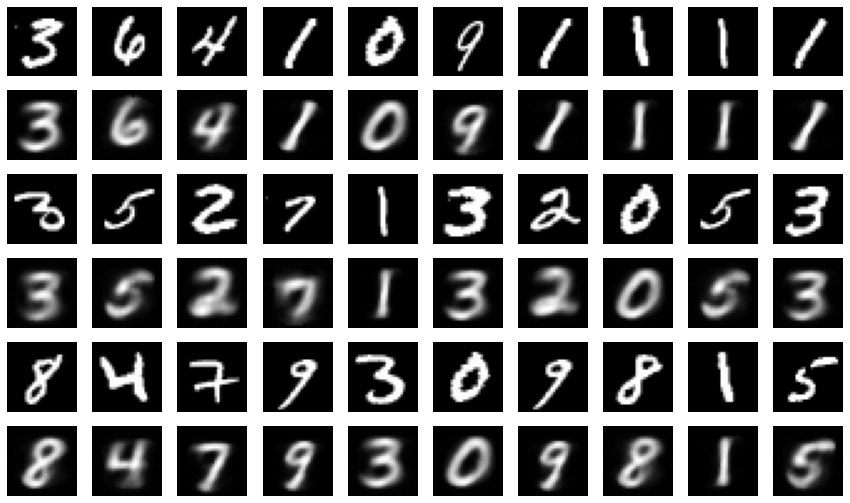

In [3]:
# Make model, load pretrained weights, compare original to reconstructed images

batch_size = 50
try:
   train_dataset
except NameError:
   train_dataset, test_dataset, ntrain, ntest=loadMNIST(batch_size)

model = MyModel()
model.__init__()

model.load_weights('capsules_weights-16-04-2020-15_41_36')
for (x,t) in train_dataset:
    bs=x.shape[0]
    if bs==batch_size:                      # process only full batches
      loss, accuracy, rec_loss, reconstructed_image, y_test,y_pred,original_image=model({'x':x,'y':t,'bypass':False})
    break;

from random import random
fig, ax = plt.subplots(6,10)
fig.set_size_inches(15, 9)
for i in range(10):
  for j in range(3):
    k=int(50*random())
    im2 = reconstructed_image[k]
    im2=tf.reshape(im2, (28, 28))
    img = original_image[k]
    img=tf.reshape(img, (28, 28))
    ax[2*j+0,i].imshow(img, cmap='gray')
    ax[2*j+1,i].imshow(im2, cmap='gray')
    ax[2*j+0,i].axis("off")
    ax[2*j+1,i].axis("off")
    

# Try to find the 'meaning' of capsule output vector components

6


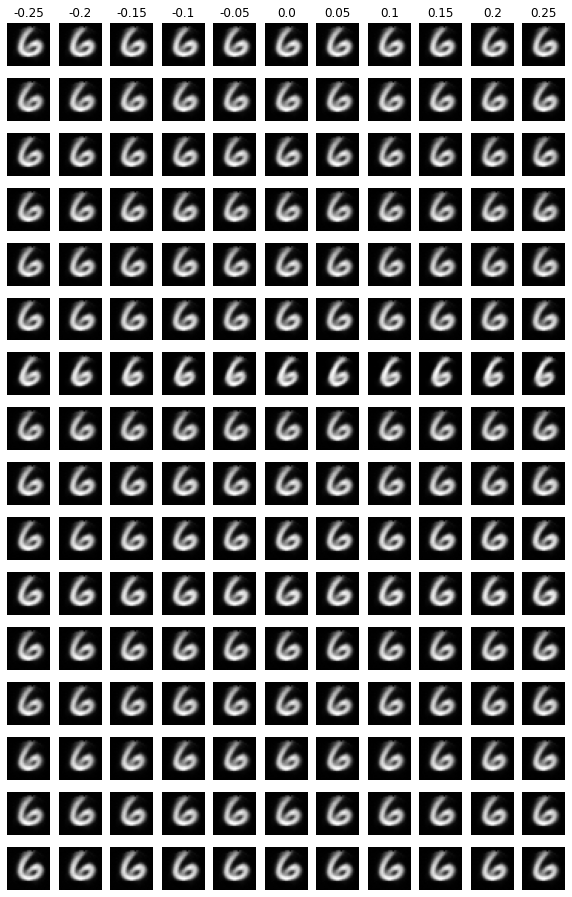

In [10]:
batch_size = 50
try:
   train_dataset
except NameError:
   train_dataset, test_dataset, ntrain, ntest=loadMNIST(batch_size)

model = MyModel()
model.__init__()
set_verbosity(0)
model.load_weights('capsules_weights-16-04-2020-15_41_36')
n=5
for (x,t) in train_dataset:
    bs=x.shape[0]
    if bs==batch_size:                      # process only full batches
      y0=t
      loss, accuracy, rec_loss, reconstructed_image, y,output_vectors,original_image=model({'x':x,'y':t,'bypass':False})
    n-=1  
    if n==0:
      break;

set_verbosity(0)

from random import random

k=int(50*random())  # random index, take one example from batch
v_jk = output_vectors[k]       # capsules output vector of the kth image
label = y0[k]       # label of kth image

T = tf.one_hot(label, depth = 10)
sprint('T',T)
T_reshaped = tf.reshape(T, [10, 1])
sprint('T_reshaped',T_reshaped)

sprint('v_jk',v_jk)
v_jk_masked = tf.multiply(v_jk, T_reshaped)
sprint('v_jk_masked',v_jk_masked)
v_j2 = tf.reshape(v_jk_masked, [1, 10, 16])
#v_j2 = tf.reshape(v_jk, [1, 10, 16])

sprint('v_j2',v_j2)
v_j3 = tf.tile(v_j2, [176, 1, 1])
sprint('v_j3',v_j3)
x2 = tf.reshape(x[k],(1,28,28))
x2 = tf.tile(x2, [176, 1, 1])         # model needs input images to determine batch size
sprint('v_j2',v_j2)
sprint('x2',x2)

#
# convert to numpy array so single array elements can be manipulated:
#
v_j3n = v_j3.numpy()   
# 
yi=label.numpy()
print(yi)
# perform manipulations
for change_step in range (11):
  perturbation = -0.25+0.05*change_step
  for dimension_to_tweak in range (16):
    #perturbation = -0.9+0.18*change_step
    vector_to_change = 16*change_step+dimension_to_tweak
    v_j3n[vector_to_change][yi][dimension_to_tweak]=perturbation

v_j4=tf.convert_to_tensor(v_j3n)
"""
sprint('v_j4',v_j4)
print('v_j4',v_j4[2])
print('v_j4',v_j4[3])

print('v_j4',v_j4[2+16])
print('v_j4',v_j4[3+16])

"""
# process batch of tweaked vectors by decoder:
l, a, r, rec_image, y1,yp,o=model({'x':x2,'y':t,'bypass':True,'v':v_j4})


fig, ax = plt.subplots(16,11)
fig.set_size_inches(10, 16)
# display reconstructed images from batch:
for change_step in range (11):
  for dimension_to_tweak in range (16):
    
    vector_to_change = 16*change_step+dimension_to_tweak
    im3 = rec_image[vector_to_change]
    im3 = tf.reshape(im3, (28, 28))
    ax[dimension_to_tweak,change_step].imshow(im3, cmap='gray')
    ax[dimension_to_tweak,change_step].axis("off")
    if dimension_to_tweak==0:
      #perturbation = np.floor(100*(-0.9+0.18*change_step))/100
      perturbation = np.floor(100*(-0.25+0.05*change_step))/100
      #print(perturbation)
      ax[dimension_to_tweak,change_step].set_title(str(perturbation))
